In [12]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import IPython
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import shutil


In [3]:
# cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Generate the one hot encoded supervised dataset
ds_variation = 'negative'
output_dir = 'mnist_neg'

# make the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the one-hot encoding function
def one_hot_encode(label, num_classes=10, random=False):
    one_hot = np.zeros(num_classes)
    if not random:
        one_hot[label] = 1
    else:
        one_hot[np.random.randint(0, num_classes)] = 1
    return one_hot

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Create new datasets and copy over the data and targets
train_neg_dataset = []
test_neg_dataset = []

for dataset, neg_dataset in [(train_dataset, train_neg_dataset), (test_dataset, test_neg_dataset)]:
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        if ds_variation == 'positive':
            one_hot = one_hot_encode(label, random=False)
        elif ds_variation == 'negative':
            one_hot = one_hot_encode(label, random=True)
        # Replace the first 10 values in the image with the one-hot encoding
        neg_image = torch.cat((torch.tensor(one_hot), image.view(-1)[10:]))
        neg_dataset.append((neg_image, label))

train_aug_images, train_aug_labels = zip(*train_neg_dataset)
test_aug_images, test_aug_labels = zip(*test_neg_dataset)

train_neg_dataset = torch.utils.data.TensorDataset(torch.stack(train_aug_images), torch.tensor(train_aug_labels))
test_neg_dataset = torch.utils.data.TensorDataset(torch.stack(test_aug_images), torch.tensor(test_aug_labels))

# Save the datasets in hdf5 format
dataset_dir = Path(output_dir)
train_file = os.path.join(dataset_dir, 'train.hdf5')
test_file = os.path.join(dataset_dir, 'test.hdf5')

with h5py.File(train_file, 'w') as f:
    f.create_dataset('input', data=train_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=train_neg_dataset.tensors[1].numpy())

with h5py.File(test_file, 'w') as f:
    f.create_dataset('input', data=test_neg_dataset.tensors[0].numpy())
    f.create_dataset('target', data=test_neg_dataset.tensors[1].numpy())

 12%|█▏        | 7354/60000 [00:00<00:06, 7931.03it/s]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

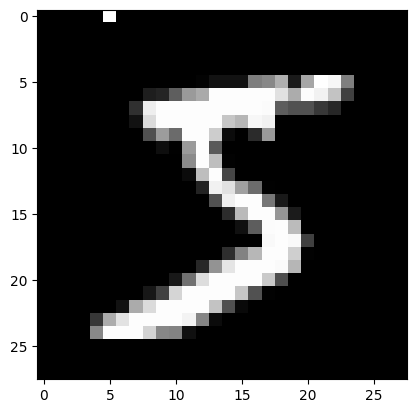

In [ ]:
# Plot the first image of the train_aug_dataset with small figure size
plt.imshow(train_neg_dataset[0][0].view(28, 28), cmap='gray')

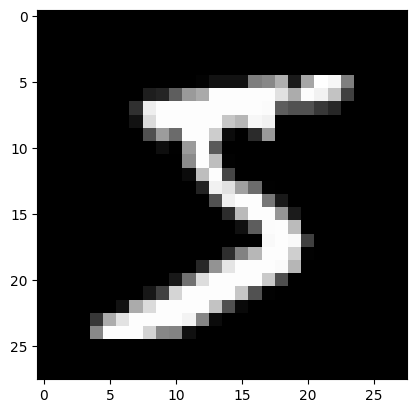

In [ ]:
# Plot the first image of the train_dataset
plt.imshow(train_dataset[0][0].view(28, 28), cmap='gray')

In [17]:
# Load a HDF5 dataset
import h5py

def load_hdf5_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        input = f['input'][:]
        target = f['target'][:]
    return input, target

# Load the datasets
train_input, train_target = load_hdf5_dataset('mnist_pos/train.hdf5')
train_neg_input, train_neg_target = load_hdf5_dataset('mnist_neg/train.hdf5')
# Load test sets
test_input, test_target = load_hdf5_dataset('mnist_pos/test.hdf5')

# Move to cuda
train_input = torch.tensor(train_input).to(device)
train_target = torch.tensor(train_target).to(device)
train_neg_input = torch.tensor(train_neg_input).to(device)
train_neg_target = torch.tensor(train_neg_target).to(device)
test_input = torch.tensor(test_input).to(device)
test_target = torch.tensor(test_target).to(device)

type(test_input)

torch.Tensor

In [26]:
# Build the forward forward net

# delete all files in output folder
# if output folder eixst
if os.path.exists('output'):
    shutil.rmtree('output')
os.makedirs('output')

torch.manual_seed(42)

# Hyperparameters
lr = 1e-3
batch_size = 64
num_epoch = 100
eval_save_interval = 10000

class ForwardForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = LinearBlock(in_features=784, out_features=2000)
        self.hidden2 = LinearBlock(in_features=2000, out_features=2000)
        self.hidden3 = LinearBlock(in_features=2000, out_features=2000)
        self.hidden4 = LinearBlock(in_features=2000, out_features=2000)
        self.output = nn.Linear(6000, 10)
        self.softmax = nn.Softmax(dim=1)
        self.training = True

    def forward(self, x_pos, x_neg):
        out1_pos, out1_neg, loss1 = self.hidden1(x_pos, x_neg)
        out2_pos, out2_neg, loss2 = self.hidden2(out1_pos, out1_neg)
        out3_pos, out3_neg, loss3 = self.hidden3(out2_pos, out2_neg)
        out4_pos, out4_neg, loss4 = self.hidden4(out3_pos, out3_neg)

        # # concatenate final 3 layers and put it through a classifier layer
        # cat = torch.cat((out2, out3, out4), dim=1)
        # logits = self.output(cat)
        # probs = self.softmax(logits)

        # Avg loss
        loss = (loss1 + loss2 + loss3 + loss4) / 4
        return _, loss

class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.relu = nn.ReLU()
        self.layernorm = nn.LayerNorm(out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.threshold = 2.0
        
    def forward(self, x_pos, x_neg):
        # Compute goodness
        g_pos = self.relu(self.linear(x_pos)).pow(2).mean(1)
        g_neg = self.relu(self.linear(x_neg)).pow(2).mean(1)

        loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Layer Norm
        out_pos = self.layernorm(self.relu(self.linear(x_pos))).detach()
        out_neg = self.layernorm(self.relu(self.linear(x_neg))).detach()

        return out_pos, out_neg, loss

# Train loader for train_input
train_loader = torch.utils.data.DataLoader(train_input, batch_size=batch_size, shuffle=True, drop_last=True)
train_neg_loader = torch.utils.data.DataLoader(train_neg_input, batch_size=batch_size, shuffle=True, drop_last=True)


m = ForwardForwardNet()
m.to(device)

# Train the forward forward net
for i in range(num_epoch):
    for iter, (x_pos, x_neg) in tqdm(enumerate(zip(train_loader, train_neg_loader)), total=len(train_loader)):
        x_pos = x_pos.view(batch_size, -1).float()
        x_neg = x_neg.view(batch_size, -1).float()

        _, loss = m(x_pos, x_neg)

        # Every X iters, get the average of the last X iters and evaluate
        if iter % eval_save_interval == 0 and iter != 0:
            print(f'Iter {iter}: Loss {loss.item()}')
            # evaluate_model()
            torch.save(m.state_dict(), f'./output/ff_net_{i}_{iter}.pt')

 50%|████▉     | 468/937 [00:02<00:02, 186.01it/s]


KeyboardInterrupt: 

In [10]:
# load a statedict
m.load_state_dict(torch.load('./output/ff_net_0_500.pt'))

OrderedDict([('hidden1.linear.weight',
              tensor([[ 6.0446e-02,  1.4709e-01, -1.8893e-02,  ..., -1.4155e-02,
                        9.2947e-03,  1.3469e-02],
                      [-4.1331e-02,  9.4467e-02, -1.7078e-02,  ..., -1.0606e-02,
                       -1.3050e-04,  1.1464e-02],
                      [ 6.8625e-02,  6.7540e-02,  9.4747e-03,  ..., -1.2676e-02,
                       -1.8839e-02,  5.8522e-03],
                      ...,
                      [ 7.8360e-02, -2.4656e-02, -3.1695e-02,  ...,  3.5621e-02,
                        3.5547e-02, -3.4971e-02],
                      [ 6.4718e-02,  6.3434e-02, -2.4005e-02,  ..., -3.0320e-02,
                       -1.1202e-02,  1.5879e-02],
                      [ 7.8743e-02,  2.9734e-02,  1.3350e-03,  ..., -2.6928e-02,
                       -1.4568e-03,  1.3764e-02]], device='cuda:0')),
             ('hidden1.layernorm.weight',
              tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')),
             (